<a href="https://colab.research.google.com/github/WARDATUSSYIFA/cobain/blob/main/Copy_of_Kelompok_13_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
!pip install pyro-ppl
!pip install numpy scipy scikit-learn
!pip install --upgrade pip
!pip install scikit-optimize
!pip install torch pyro-ppl scikit-learn scikit-optimize

In [ ]:
import pandas as pd
import uuid
import matplotlib.pyplot as plt
import seaborn as sn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.base import BaseEstimator, ClassifierMixin

# Preparing Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('Dataset of Diabetes.csv')
print(df)

# 1. Cek jumlah data hilang per kolom
print("Jumlah Data Hilang per Kolom:")
print(df.isnull().sum())

# 2. Cek persentase data hilang per kolom
print("\nPersentase Data Hilang per Kolom (%):")
print((df.isnull().sum() / len(df) * 100).round(2))

# 3. Cek total data hilang di seluruh dataset
print("\nTotal Data Hilang di Seluruh Dataset:")
print(df.isnull().sum().sum())

      ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0    502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1    735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2    420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3    680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4    504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   
..   ...        ...    ...  ...   ...  ..    ...   ...  ...  ...  ...   ...   
995  200     454317      M   71  11.0  97    7.0   7.5  1.7  1.2  1.8   0.6   
996  671     876534      M   31   3.0  60   12.3   4.1  2.2  0.7  2.4  15.4   
997  669      87654      M   30   7.1  81    6.7   4.1  1.1  1.2  2.4   8.1   
998   99      24004      M   38   5.8  59    6.7   5.3  2.0  1.6  2.9  14.0   
999  248      24054      M   54   5.0  67    6.9   3.8  1.7  1.1  3.0   0.7   

      BMI CLASS  
0    24.0     N  
1    23.0     N

In [ ]:
# 4. Hitung jumlah data untuk setiap kategori di kolom CLASS
class_counts = df['CLASS'].value_counts()

# 5. Tampilkan hasil
print("Jumlah Data per Kategori CLASS:")
print(class_counts)

# 6. Tampilkan dalam bentuk persentase
print("\nPersentase Data per Kategori CLASS (%):")
print((df['CLASS'].value_counts(normalize=True) * 100).round(2))

Jumlah Data per Kategori CLASS:
CLASS
Y     840
N     102
P      53
Y       4
N       1
Name: count, dtype: int64

Persentase Data per Kategori CLASS (%):
CLASS
Y     84.0
N     10.2
P      5.3
Y      0.4
N      0.1
Name: proportion, dtype: float64


# Cleaning data

In [ ]:
# 1. Hapus kolom ID dan No_Pation
df = df.drop(['ID', 'No_Pation'], axis=1)

# 2. Samakan format amatan
# Gender: Standardize 'F', 'M', 'f' to 'F' and 'M'
df['Gender'] = df['Gender'].str.strip().replace({'f': 'F'})

# CLASS: Standardize 'N', 'N ', 'P', 'Y', 'Y ' to 'N' and 'Y'
df['CLASS'] = df['CLASS'].str.strip().replace({'N ': 'N', 'Y ': 'Y'})

# For categorical columns (Gender, CLASS), fill with mode
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].fillna(df[column].mode()[0])
# 3. Hitung jumlah data untuk setiap kategori di kolom CLASS
class_counts = df['CLASS'].value_counts()

# 4. Tampilkan hasil
print("Jumlah Data per Kategori CLASS:")
print(class_counts)

# 5. Tampilkan dalam bentuk persentase
print("\nPersentase Data per Kategori CLASS (%):")
print((df['CLASS'].value_counts(normalize=True) * 100).round(2))

Jumlah Data per Kategori CLASS:
CLASS
Y    844
N    103
P     53
Name: count, dtype: int64

Persentase Data per Kategori CLASS (%):
CLASS
Y    84.4
N    10.3
P     5.3
Name: proportion, dtype: float64


In [ ]:
# 6. Menghapus kelas P yang mengartikan kelas prediksi
df = df[df['CLASS'] != 'P']
class_counts = df['CLASS'].value_counts()

# 7. Tampilkan hasil
print("Jumlah Data per Kategori CLASS:")
print(class_counts)

# 8. Tampilkan dalam bentuk persentase
print("\nPersentase Data per Kategori CLASS (%):")
print((df['CLASS'].value_counts(normalize=True) * 100).round(2))

Jumlah Data per Kategori CLASS:
CLASS
Y    844
N    103
Name: count, dtype: int64

Persentase Data per Kategori CLASS (%):
CLASS
Y    89.12
N    10.88
Name: proportion, dtype: float64


In [ ]:
# 6. Tangani amatan duplikat
# Remove duplicate rows, keeping the first occurrence
df = df.drop_duplicates()

# 7. Encode peubah kategorik
# Gender: 'F' -> 0, 'M' -> 1
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})

# CLASS: 'N' -> 0, 'Y' -> 1
df['CLASS'] = df['CLASS'].map({'N': 0, 'Y': 1})

# Verify the number of rows (should be 826 after deduplication)
print(f"Number of rows after preprocessing: {len(df)}")

# 8. Save the preprocessed dataset
df.to_csv('preprocessed_diabetes_dataset.csv', index=False)

# Display the first few rows of the preprocessed dataset
print(df.head())

# 9. Hitung jumlah data untuk setiap kategori di kolom CLASS
class_counts = df['CLASS'].value_counts()

# 10. Tampilkan hasil
print("Jumlah Data per Kategori CLASS:")
print(class_counts)

# 11. Tampilkan dalam bentuk persentase
print("\nPersentase Data per Kategori CLASS (%):")
print((df['CLASS'].value_counts(normalize=True) * 100).round(2))


Number of rows after preprocessing: 786
   Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI  CLASS
0       0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      0
1       1   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0      0
4       1   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0      0
5       0   45   2.3  24    4.0   2.9  1.0  1.0  1.5   0.4  21.0      0
6       0   50   2.0  50    4.0   3.6  1.3  0.9  2.1   0.6  24.0      0
Jumlah Data per Kategori CLASS:
CLASS
1    690
0     96
Name: count, dtype: int64

Persentase Data per Kategori CLASS (%):
CLASS
1    87.79
0    12.21
Name: proportion, dtype: float64


<ipython-input-43-1133341015>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})
<ipython-input-43-1133341015>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASS'] = df['CLASS'].map({'N': 0, 'Y': 1})


# Eksplorasi data

Statistik Deskriptif untuk Setiap Peubah:
           Gender         AGE        Urea          Cr       HbA1c        Chol  \
count  786.000000  786.000000  786.000000  786.000000  786.000000  786.000000   
mean     0.554707   54.003817    5.217230   69.017812    8.444097    4.922290   
std      0.497315    8.554135    3.110644   60.140936    2.613438    1.335687   
min      0.000000   20.000000    0.500000    6.000000    0.900000    0.000000   
25%      0.000000   51.000000    3.670000   47.250000    6.800000    4.100000   
50%      1.000000   55.000000    4.600000   59.000000    8.300000    4.800000   
75%      1.000000   59.750000    5.800000   73.000000   10.300000    5.700000   
max      1.000000   79.000000   38.900000  800.000000   16.000000   10.300000   

               TG         HDL         LDL        VLDL         BMI       CLASS  
count  786.000000  786.000000  786.000000  786.000000  786.000000  786.000000  
mean     2.412188    1.216094    2.601260    1.813613   29.731374   

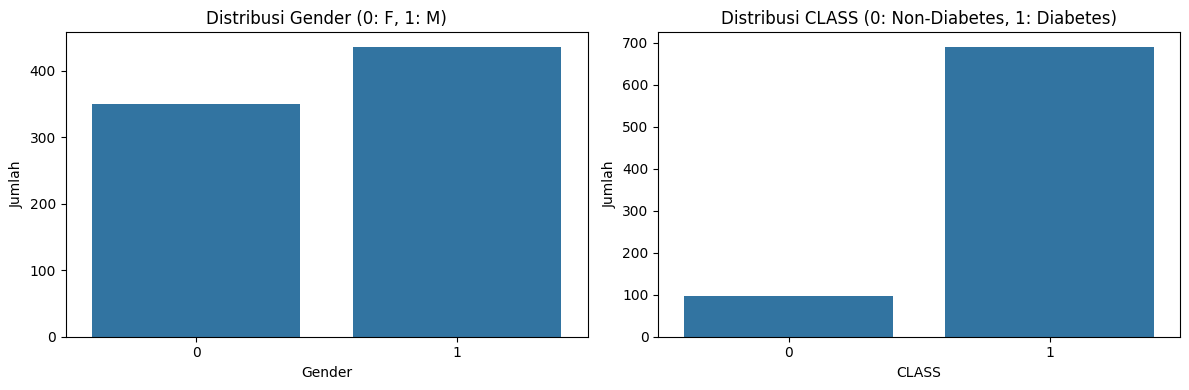

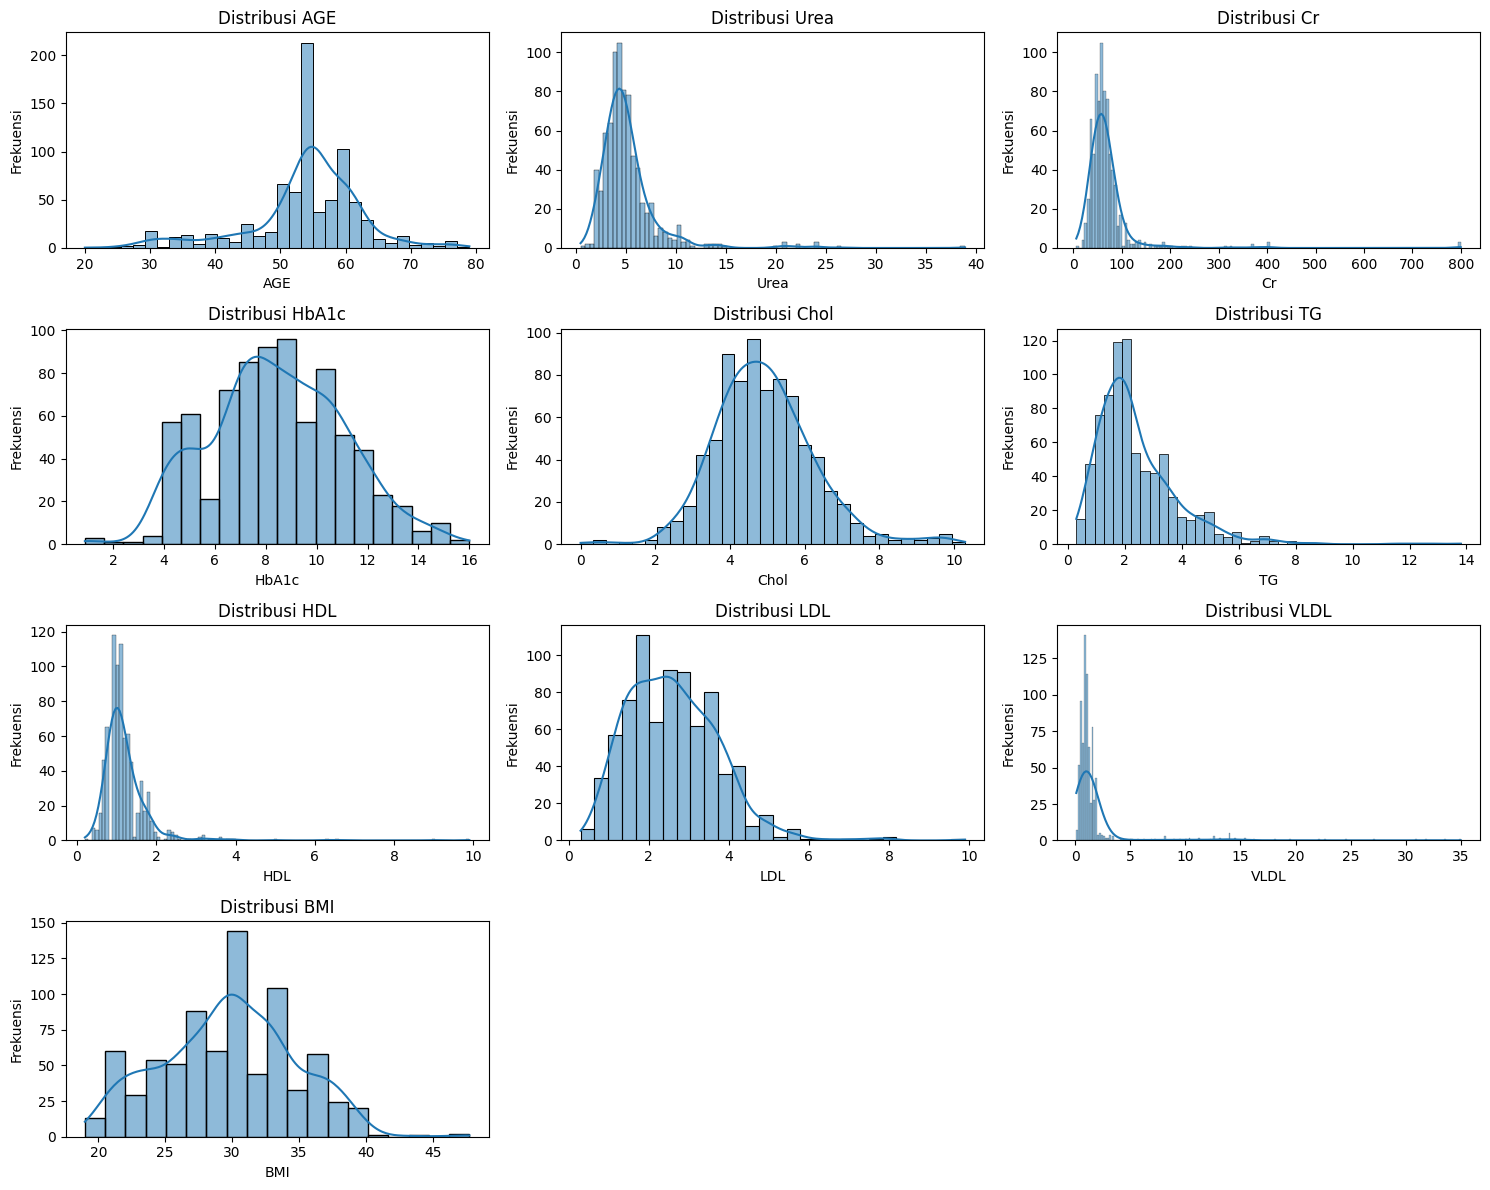

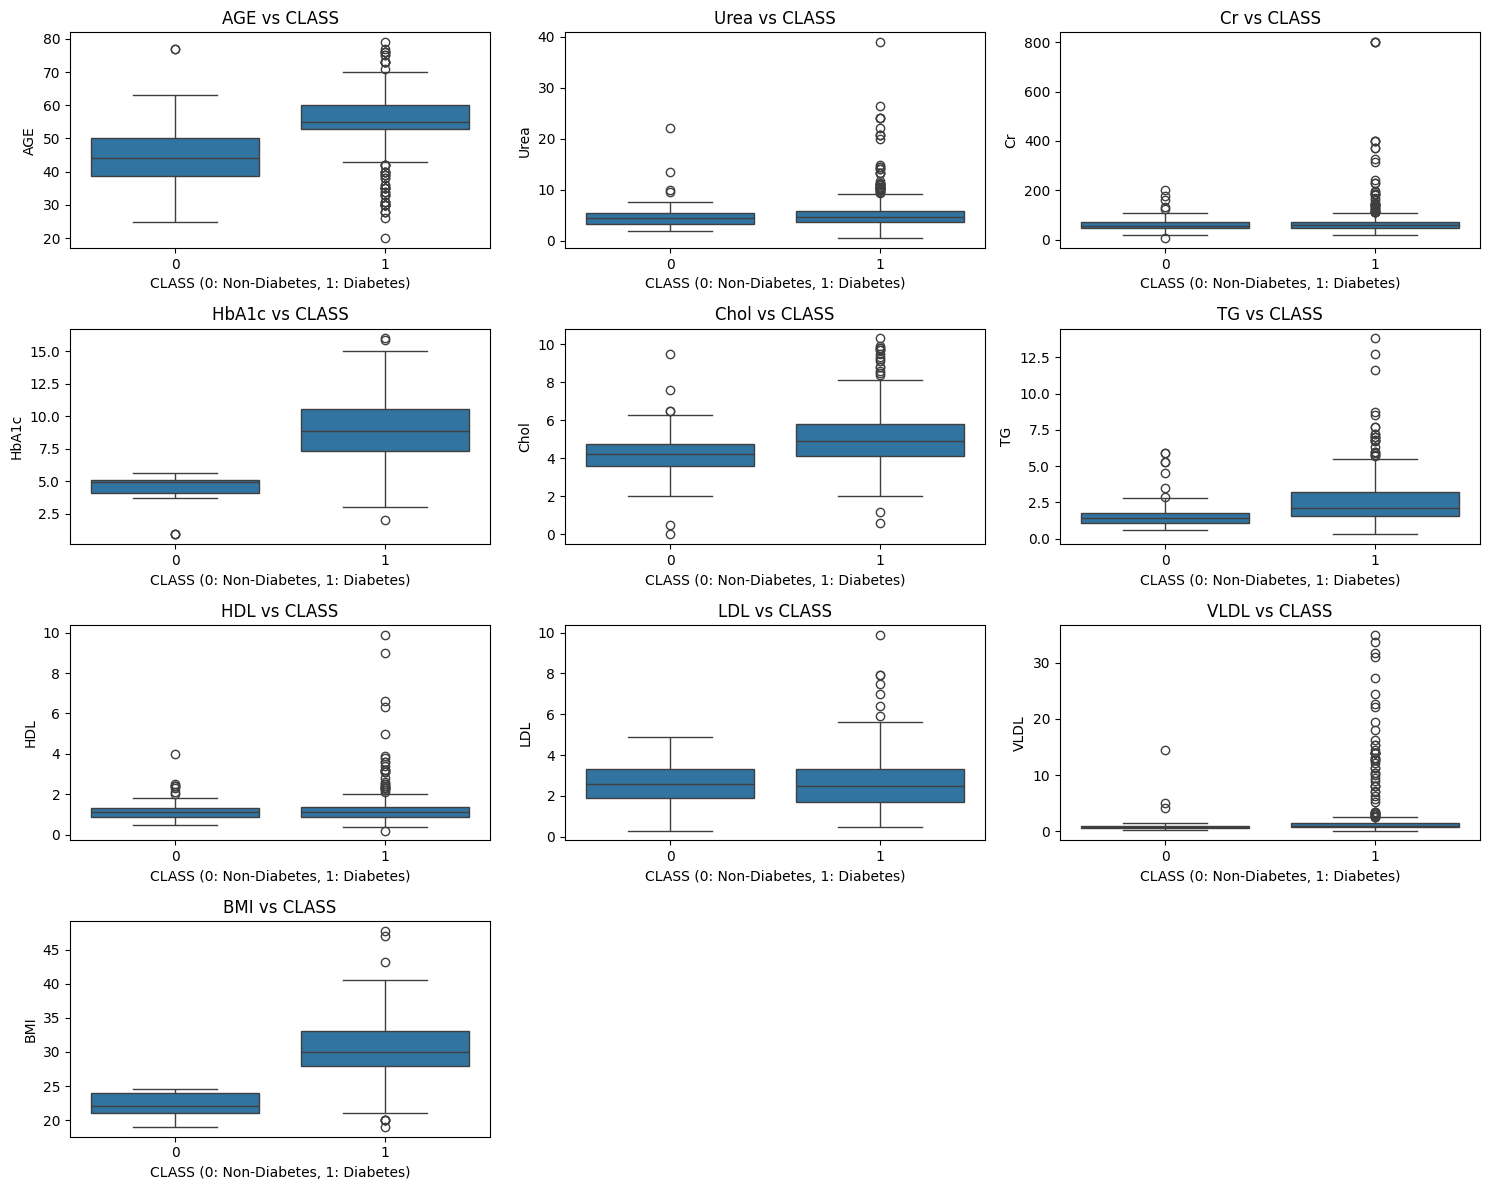

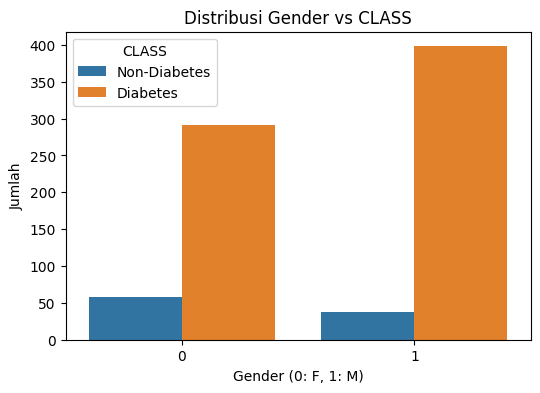

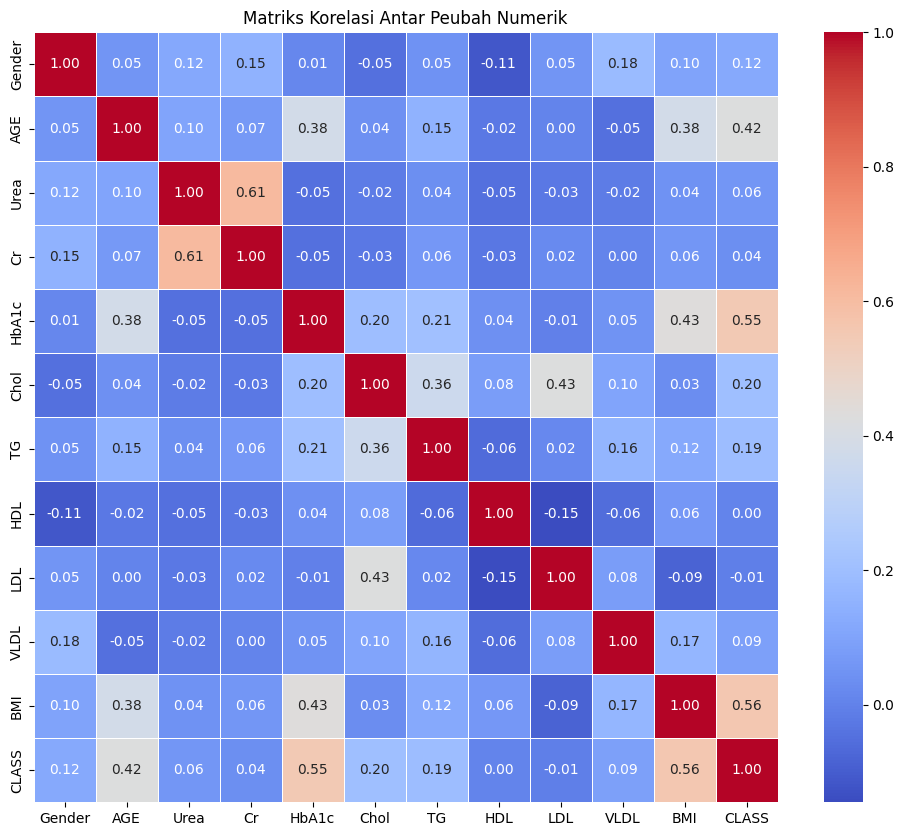

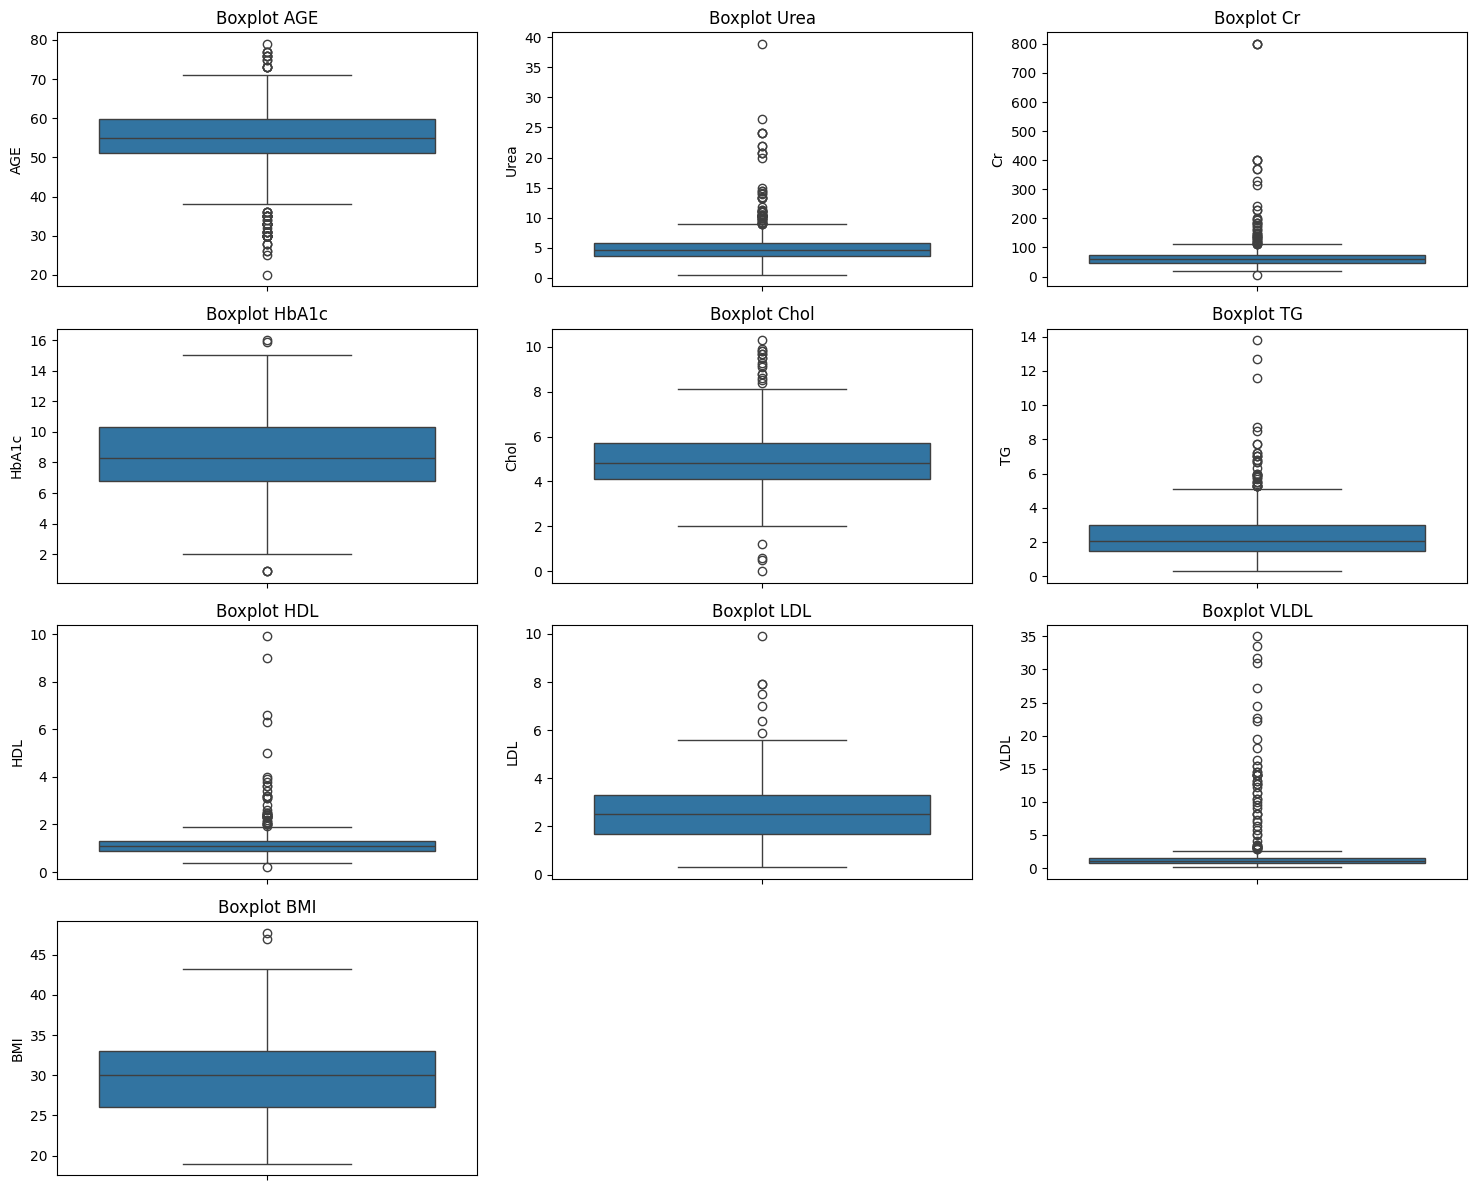


Jumlah Outlier per Peubah Numerik:
AGE: 65 outlier
Urea: 54 outlier
Cr: 43 outlier
HbA1c: 5 outlier
Chol: 20 outlier
TG: 34 outlier
HDL: 41 outlier
LDL: 7 outlier
VLDL: 54 outlier
BMI: 2 outlier


In [ ]:
# Load dataset yang sudah dipreproses
df = pd.read_csv('preprocessed_diabetes_dataset.csv')

# Daftar peubah
variables = ['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS']

# 1. Statistik Deskriptif
print("Statistik Deskriptif untuk Setiap Peubah:")
print(df[variables].describe(include='all'))

# 2. Distribusi Data
# Peubah Kategorikal: Gender, CLASS
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(x='Gender', data=df)
plt.title('Distribusi Gender (0: F, 1: M)')
plt.xlabel('Gender')
plt.ylabel('Jumlah')

plt.subplot(1, 2, 2)
sns.countplot(x='CLASS', data=df)
plt.title('Distribusi CLASS (0: Non-Diabetes, 1: Diabetes)')
plt.xlabel('CLASS')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

# Peubah Numerik: AGE, Urea, Cr, HbA1c, Chol, TG, HDL, LDL, VLDL, BMI
numeric_vars = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
plt.figure(figsize=(15, 12))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribusi {var}')
    plt.xlabel(var)
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# 3. Hubungan dengan CLASS
plt.figure(figsize=(15, 12))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='CLASS', y=var, data=df)
    plt.title(f'{var} vs CLASS')
    plt.xlabel('CLASS (0: Non-Diabetes, 1: Diabetes)')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

# Hubungan Gender dengan CLASS
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', hue='CLASS', data=df)
plt.title('Distribusi Gender vs CLASS')
plt.xlabel('Gender (0: F, 1: M)')
plt.ylabel('Jumlah')
plt.legend(title='CLASS', labels=['Non-Diabetes', 'Diabetes'])
plt.show()

# Analisis Korelasi
# Pilih kolom numerik untuk analisis korelasi
numeric_cols = df.select_dtypes(include=np.number).columns
# Hitung matriks korelasi
correlation_matrix = df[numeric_cols].corr()
# Visualisasikan matriks korelasi menggunakan heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Matriks Korelasi Antar Peubah Numerik')
plt.show()

# 4. Deteksi Outlier
plt.figure(figsize=(15, 12))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=df[var])
    plt.title(f'Boxplot {var}')
plt.tight_layout()
plt.show()

# 5. Jumlah Outlier (menggunakan metode IQR)
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

print("\nJumlah Outlier per Peubah Numerik:")
for var in numeric_vars:
    print(f"{var}: {detect_outliers(df, var)} outlier")

# Balancing Data

In [ ]:
# Load dataset yang sudah dipreproses
df = pd.read_csv('preprocessed_diabetes_dataset.csv')

# 2. Pisahkan fitur (X) dan target (y)
X = df.drop('CLASS', axis=1)  # Fitur: Gender, AGE, Urea, dll.
y = df['CLASS']  # Target: CLASS (0: N, 1: Y)

numeric_cols = X.drop(['Gender'], axis=1).columns
categorical_cols = X[['Gender']]

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoders = {}

# Apply Label Encoding to each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

le_y = LabelEncoder()

y = le_y.fit_transform(y)

# Normalisasi fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Bagi data menjadi latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Melihat jumlah data pelatihan dan pengujian
print("Jumlah data pelatihan (X_train):", X_train.shape[0])
print("Jumlah data pengujian (X_test):", X_test.shape[0])
print("Jumlah label pelatihan (y_train):", len(y_train))
print("Jumlah label pengujian (y_test):", len(y_test))

# Opsional: Melihat dimensi fitur
print("Dimensi X_train:", X_train.shape)
print("Dimensi X_test:", X_test.shape)

# 1. Cek distribusi CLASS sebelum balancing

# Count class distribution in y_train
classes, counts = np.unique(y_train, return_counts=True)
print("Distribusi CLASS TRAIN sebelum balancing:")
# Print results
for cls, count in zip(classes, counts):
    print(f"Class {cls}: {count} samples")

# 3. Balancing dengan SMOTE (Oversampling)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Gabungkan kembali data setelah SMOTE
df_smote = pd.concat([pd.DataFrame(X_smote, columns=df.drop('CLASS', axis=1).columns), pd.DataFrame(y_smote, columns=['CLASS'])], axis=1)

# Cek distribusi CLASS setelah SMOTE
print("\nDistribusi CLASS TRAIN setelah SMOTE:")
print(df_smote['CLASS'].value_counts())

# Simpan dataset yang sudah di-balance dengan SMOTE
df_smote.to_csv('balanced_diabetes_dataset_smote.csv', index=False)

Jumlah data pelatihan (X_train): 628
Jumlah data pengujian (X_test): 158
Jumlah label pelatihan (y_train): 628
Jumlah label pengujian (y_test): 158
Dimensi X_train: (628, 11)
Dimensi X_test: (158, 11)
Distribusi CLASS TRAIN sebelum balancing:
Class 0: 73 samples
Class 1: 555 samples

Distribusi CLASS TRAIN setelah SMOTE:
CLASS
1    555
0    555
Name: count, dtype: int64


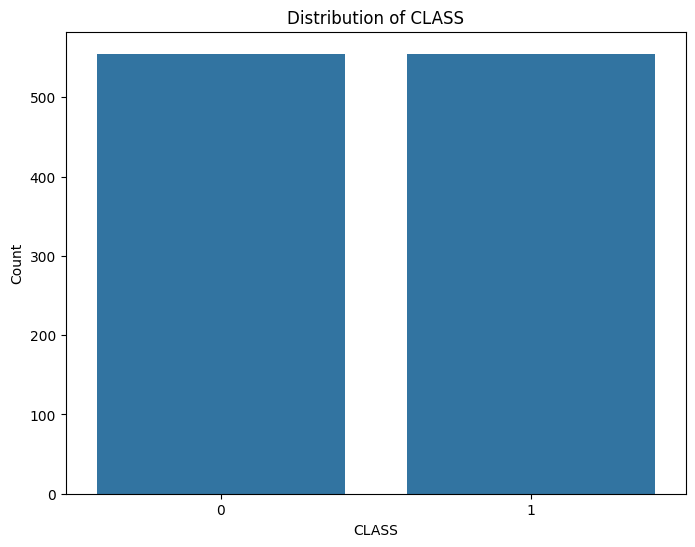

In [ ]:
# prompt: Barplot of CLASS
plt.figure(figsize=(8, 6))
sns.countplot(x='CLASS', data=pd.DataFrame({'CLASS': y_smote}))
plt.title('Distribution of CLASS')
plt.xlabel('CLASS')
plt.ylabel('Count')
plt.show()

# Analisis BNN Tanpa Tuning

In [ ]:
# Konversi ke tensor PyTorch, pakai smote
X_train = torch.tensor(X_smote, dtype=torch.float32)
y_train = torch.tensor(y_smote, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

Iterasi 0, Loss: 2.9220
Iterasi 100, Loss: 1.0840
Iterasi 200, Loss: 0.6695
Iterasi 300, Loss: 0.4581
Iterasi 400, Loss: 0.3770
Iterasi 500, Loss: 0.4831
Iterasi 600, Loss: 0.3976
Iterasi 700, Loss: 0.3097
Iterasi 800, Loss: 0.3133
Iterasi 900, Loss: 0.2983


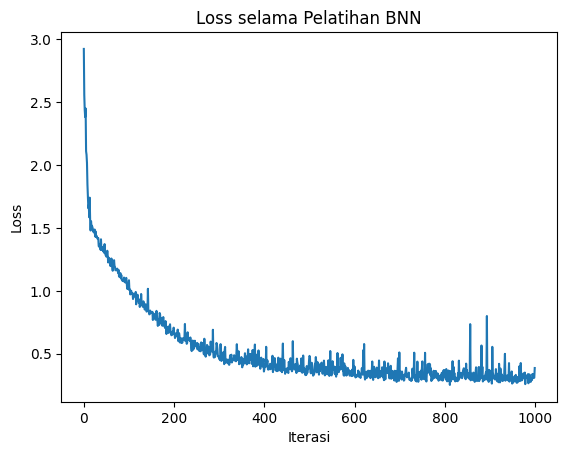


Evaluasi Model BNN pada Data Uji:
Akurasi: 0.9747
Precision: 0.9925
Recall: 0.9778
F1-Score: 0.9851
AUC-ROC: 0.9963

Evaluasi Model BNN pada Data Latih:
Akurasi: 0.9766
Precision: 0.9871
Recall: 0.9658
F1-Score: 0.9763
AUC-ROC: 0.9976


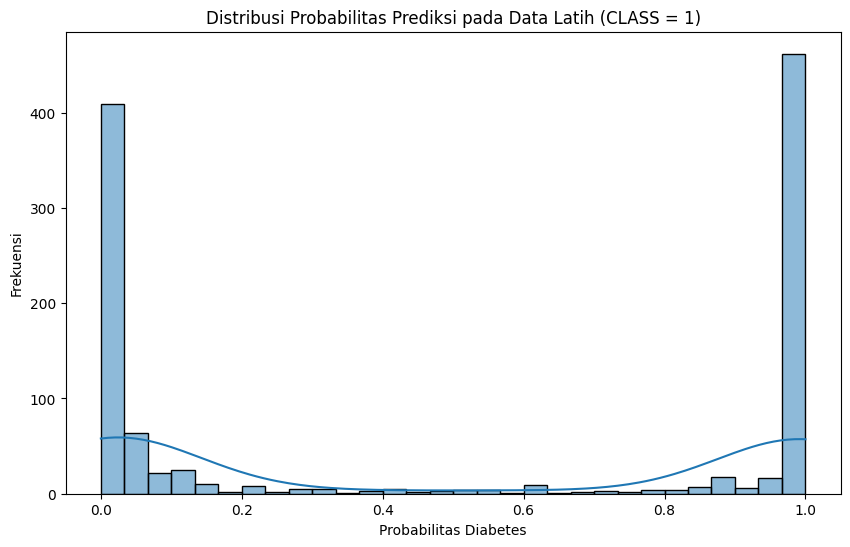

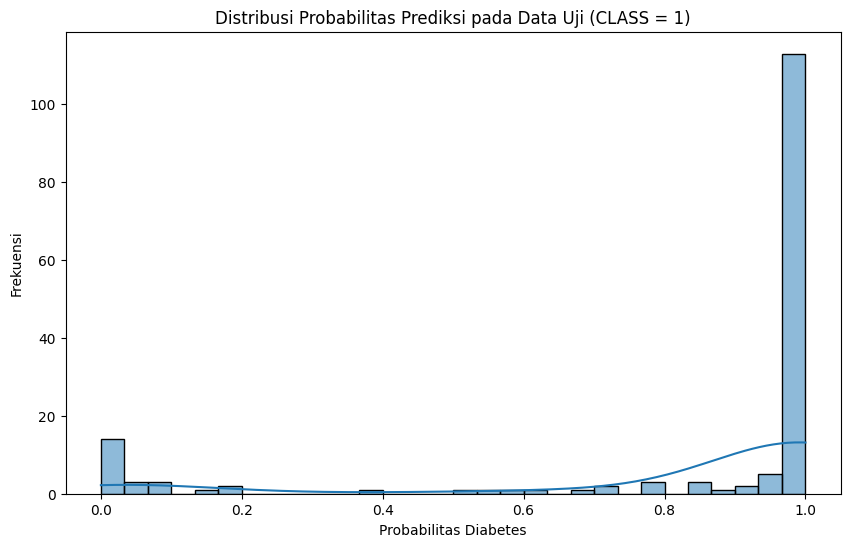

In [ ]:
# Definisikan model BNN
class BNN(PyroModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Lapisan pertama
        self.fc1 = PyroModule[torch.nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_dim, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([hidden_dim]).to_event(1))

        # Lapisan kedua
        self.fc2 = PyroModule[torch.nn.Linear](hidden_dim, output_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([output_dim, hidden_dim]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([output_dim]).to_event(1))

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x).squeeze(-1)
        probs = self.sigmoid(logits)

        # Distribusi Bernoulli untuk klasifikasi biner
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Bernoulli(probs), obs=y)
        return probs

# Inisialisasi model
input_dim = X_train.shape[1]  # Jumlah fitur (11: Gender, AGE, Urea, dll.)
hidden_dim = 64
output_dim = 1
model = BNN(input_dim, hidden_dim, output_dim)

# Definisikan guide untuk Variational Inference
guide = AutoDiagonalNormal(model)

# Setup optimasi dan inference
adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

# Pelatihan model
num_iterations = 1000
pyro.clear_param_store()
losses = []

for i in range(num_iterations):
    loss = svi.step(X_train, y_train)
    losses.append(loss / len(X_train))
    if i % 100 == 0:
        print(f"Iterasi {i}, Loss: {loss / len(X_train):.4f}")

# Plot loss
plt.plot(losses)
plt.title("Loss selama Pelatihan BNN")
plt.xlabel("Iterasi")
plt.ylabel("Loss")
plt.show()

# Prediksi pada data uji
def predict(model, guide, X, num_samples=100):
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=num_samples)
    samples = predictive(X)
    probs = samples['obs'].detach().numpy().mean(axis=0)
    return probs

# Hitung probabilitas prediksi dan ketidakpastian pada data uji
probs_test = predict(model, guide, X_test)
y_pred_test_bnn = (probs_test > 0.5).astype(int)
uncertainty_test = probs_test.std(axis=0)  # Ketidakpastian dari distribusi prediksi

# Evaluasi model pada data uji
accuracy_test = accuracy_score(y_test, y_pred_test_bnn)
precision_test = precision_score(y_test, y_pred_test_bnn)
recall_test = recall_score(y_test, y_pred_test_bnn)
f1_test = f1_score(y_test, y_pred_test_bnn)
auc_test = roc_auc_score(y_test, probs_test)

print("\nEvaluasi Model BNN pada Data Uji:")
print(f"Akurasi: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {auc_test:.4f}")

# Hitung probabilitas prediksi dan ketidakpastian pada data latih
probs_train = predict(model, guide, X_train)
y_pred_train_bnn = (probs_train > 0.5).astype(int)
uncertainty_train = probs_train.std(axis=0)  # Ketidakpastian dari distribusi prediksi

# Evaluasi model pada data latih
accuracy_train = accuracy_score(y_train, y_pred_train_bnn)
precision_train = precision_score(y_train, y_pred_train_bnn)
recall_train = recall_score(y_train, y_pred_train_bnn)
f1_train = f1_score(y_train, y_pred_train_bnn)
auc_train = roc_auc_score(y_train, probs_train)

print("\nEvaluasi Model BNN pada Data Latih:")
print(f"Akurasi: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}")
print(f"AUC-ROC: {auc_train:.4f}")

# Visualisasi distribusi probabilitas prediksi pada data latih
plt.figure(figsize=(10, 6))
sns.histplot(probs_train, kde=True, bins=30)
plt.title("Distribusi Probabilitas Prediksi pada Data Latih (CLASS = 1)")
plt.xlabel("Probabilitas Diabetes")
plt.ylabel("Frekuensi")
plt.show()

# Visualisasi distribusi probabilitas prediksi pada data uji
plt.figure(figsize=(10, 6))
sns.histplot(probs_test, kde=True, bins=30)
plt.title("Distribusi Probabilitas Prediksi pada Data Uji (CLASS = 1)")
plt.xlabel("Probabilitas Diabetes")
plt.ylabel("Frekuensi")
plt.show()

# Analisis ANN Tanpa Tuning

In [ ]:
import torch.nn as nn

# 4. Definisikan model ANN
class ANN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Dropout untuk mencegah overfitting
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x

# Inisialisasi model
input_dim = X_train.shape[1]  # Jumlah fitur (11: Gender, AGE, Urea, dll.)
hidden_dim1 = 64
hidden_dim2 = 32
model = ANN(input_dim, hidden_dim1, hidden_dim2)

# 5. Setup loss function dan optimizer
# Gunakan bobot kelas untuk menangani ketidakseimbangan (jika ada)
class_counts = np.bincount(y.astype(int))
class_weights = 1.0 / class_counts
# Create per-sample weights with the same shape as y_train
sample_weights = torch.tensor([class_weights[int(label)] for label in y_train.numpy().flatten()], dtype=torch.float32).reshape(-1, 1)
criterion = nn.BCELoss(weight=sample_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. Pelatihan model
num_epochs = 100
train_losses = []
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.unsqueeze(1))
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 7. Plot loss pelatihan
plt.plot(train_losses)
plt.title("Loss selama Pelatihan ANN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('ann_training_loss.png')
plt.close()

# 8. Evaluasi model
def evaluate_model(model, X, y_true):
    model.eval()
    with torch.no_grad():
        probs = model(X).numpy().flatten()
        y_pred = (probs > 0.5).astype(int)
        y_true = y_true.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, probs)
    return accuracy, precision, recall, f1, auc, probs,y_pred

# Evaluasi pada data latih
accuracy_train, precision_train, recall_train, f1_train, auc_train, probs_train,y_pred_train_ann = evaluate_model(model, X_train, y_train)
print("\nEvaluasi Model ANN pada Data Latih:")
print(f"Akurasi: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}")
print(f"AUC-ROC: {auc_train:.4f}")

# Evaluasi pada data uji
accuracy_test, precision_test, recall_test, f1_test, auc_test, probs_test,y_pred_test_ann = evaluate_model(model, X_test, y_test)
print("\nEvaluasi Model ANN pada Data Uji:")
print(f"Akurasi: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {auc_test:.4f}")

# 9. Visualisasi distribusi probabilitas prediksi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(probs_train, kde=True, bins=30)
plt.title("Distribusi Probabilitas Prediksi pada Data Latih (CLASS = 1)")
plt.xlabel("Probabilitas Diabetes")
plt.ylabel("Frekuensi")

plt.subplot(1, 2, 2)
sns.histplot(probs_test, kde=True, bins=30)
plt.title("Distribusi Probabilitas Prediksi pada Data Uji (CLASS = 1)")
plt.xlabel("Probabilitas Diabetes")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.savefig('ann_prediction_distributions.png')
plt.close()

Epoch [10/100], Loss: 0.0036
Epoch [20/100], Loss: 0.0029
Epoch [30/100], Loss: 0.0022
Epoch [40/100], Loss: 0.0016
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0009
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0006
Epoch [90/100], Loss: 0.0006
Epoch [100/100], Loss: 0.0005

Evaluasi Model ANN pada Data Latih:
Akurasi: 0.9135
Precision: 1.0000
Recall: 0.8270
F1-Score: 0.9053
AUC-ROC: 0.9938

Evaluasi Model ANN pada Data Uji:
Akurasi: 0.8861
Precision: 1.0000
Recall: 0.8667
F1-Score: 0.9286
AUC-ROC: 0.9984


# Evaluasi ANN dan BNN Tanpa Tuning

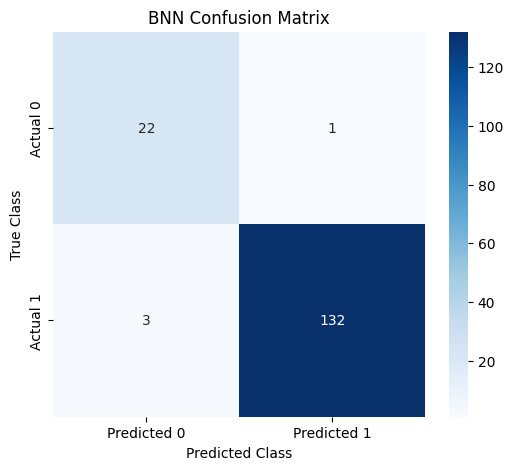

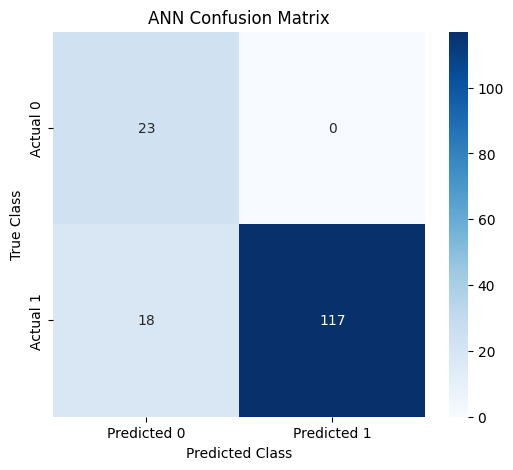

In [ ]:
from sklearn.metrics import confusion_matrix

# BNN Confusion Matrix
bnn_cm = confusion_matrix(y_test, y_pred_test_bnn)
plt.figure(figsize=(6, 5))
sns.heatmap(bnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('BNN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# ANN Confusion Matrix
ann_cm = confusion_matrix(y_test, y_pred_test_ann) # Assuming probs_test is from the ANN
plt.figure(figsize=(6, 5))
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('ANN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Analisis ANN dengan Tuning

In [ ]:
# Konversi ke tensor PyTorch, pakai smote
X_train = torch.tensor(X_smote, dtype=torch.float32)
y_train = torch.tensor(y_smote, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 4. Definisikan model ANN
class ANN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Dropout untuk mencegah overfitting
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x

# 5. Wrapper untuk ANN agar kompatibel dengan scikit-learn
class ANNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_dim1=98, hidden_dim2=32, lr=0.001, num_epochs=100):
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.lr = lr
        self.num_epochs = num_epochs
        self.model = None

    def fit(self, X, y):
        # Convert inputs to tensors
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        y = torch.tensor(y, dtype=torch.float32) if not isinstance(y, torch.Tensor) else y

        # Inisialisasi model
        self.model = ANN(self.input_dim, self.hidden_dim1, self.hidden_dim2)
        criterion = nn.BCELoss()  # Tanpa bobot karena SMOTE sudah menyeimbangkan data
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        # Pelatihan
        self.model.train()
        for epoch in range(self.num_epochs):
            optimizer.zero_grad()
            outputs = self.model(X)
            loss = criterion(outputs, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {loss.item():.4f}")
        return self

    def predict_proba(self, X):
        # Ensure X is a PyTorch tensor
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        self.model.eval()
        with torch.no_grad():
            probs = self.model(X).numpy().flatten()
        return np.vstack([1 - probs, probs]).T  # Shape (n_samples, 2) for binary classification

    def predict(self, X):
        # Ensure X is a PyTorch tensor
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        probs = self.predict_proba(X)[:, 1]
        return (probs > 0.5).astype(int)

# 6. Setup hyperparameter search space
search_space = {
    'hidden_dim1': Integer(32, 128),
    'hidden_dim2': Integer(16, 64),
    'lr': Real(0.0001, 0.01, prior='log-uniform'),
    'num_epochs': Integer(50, 150)
}

# 7. Inisialisasi wrapper model
ann_model = ANNWrapper(input_dim=X_train.shape[1])

# 8. Lakukan tuning hiperparameter dengan Bayesian optimization
bayes_search = BayesSearchCV(
    ann_model,
    search_space,
    n_iter=20,
    scoring='f1',  # Fokus pada F1-score untuk keseimbangan presisi dan recall
    cv=5,
    n_jobs=1,  # Sequential karena PyTorch tidak selalu mendukung paralelisme
    verbose=1
)

# 9. Jalankan tuning pada data latih
bayes_search.fit(X_train.numpy(), y_train.numpy())

# 10. Tampilkan parameter terbaik dan skor
print("Best parameters:", bayes_search.best_params_)
print("Best F1 score:", bayes_search.best_score_)

# 11. Evaluasi model terbaik
def evaluate_model(model, X, y_true):
    model.eval()
    with torch.no_grad():
        probs = model(X).numpy().flatten()
        y_pred = (probs > 0.5).astype(int)
        y_true = y_true.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, probs)
    return accuracy, precision, recall, f1, auc, probs, y_pred

# Evaluasi pada data latih
best_model = bayes_search.best_estimator_
accuracy_train, precision_train, recall_train, f1_train, auc_train, probs_train, y_pred_train_ann = evaluate_model(best_model.model, X_train, y_train)
print("\nEvaluasi Model ANN pada Data Latih:")
print(f"Akurasi: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}")
print(f"AUC-ROC: {auc_train:.4f}")

# Evaluasi pada data uji
accuracy_test, precision_test, recall_test, f1_test, auc_test, probs_test, y_pred_test_ann = evaluate_model(best_model.model, X_test, y_test)
print("\nEvaluasi Model ANN pada Data Uji:")
print(f"Akurasi: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {auc_test:.4f}")

# 12. Visualisasi distribusi probabilitas prediksi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(probs_train, kde=True, bins=30)
plt.title("Distribusi Probabilitas Prediksi pada Data Latih (CLASS = 1)")
plt.xlabel("Probabilitas Diabetes")
plt.ylabel("Frekuensi")

plt.subplot(1, 2, 2)
sns.histplot(probs_test, kde=True, bins=30)
plt.title("Distribusi Probabilitas Prediksi pada Data Uji (CLASS = 1)")
plt.xlabel("Probabilitas Diabetes")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.savefig('ann_prediction_distributions.png')
plt.close()

# 13. Confusion Matrix untuk Data Uji
cm = confusion_matrix(y_test.numpy(), y_pred_test_ann)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi (0)', 'Prediksi (1)'],
            yticklabels=['Actual (0)', 'Actual (1)'])
plt.title('Confusion Matrix untuk Data Uji')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.savefig('ann_confusion_matrix_test.png')
plt.close()

#14. Confusion matrix untuk data train
cm = confusion_matrix(y_train, y_pred_train_ann)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi (0)', 'Prediksi (1)'],
            yticklabels=['Actual (0)', 'Actual (1)'])
plt.title('Confusion Matrix untuk Data Latih')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.savefig('ann_confusion_matrix_train.png')
plt.close()

<ipython-input-54-3453919308>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-54-3453919308>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
<ipython-input-54-3453919308>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch [10/124], Loss: 0.5223
Epoch [20/124], Loss: 0.3468
Epoch [30/124], Loss: 0.2291
Epoch [40/124], Loss: 0.1535
Epoch [50/124], Loss: 0.1063
Epoch [60/124], Loss: 0.0955
Epoch [70/124], Loss: 0.0860
Epoch [80/124], Loss: 0.0810
Epoch [90/124], Loss: 0.0809
Epoch [100/124], Loss: 0.0674
Epoch [110/124], Loss: 0.0656
Epoch [120/124], Loss: 0.0539
Epoch [10/124], Loss: 0.5565
Epoch [20/124], Loss: 0.3754
Epoch [30/124], Loss: 0.2291
Epoch [40/124], Loss: 0.1498
Epoch [50/124], Loss: 0.1100
Epoch [60/124], Loss: 0.0896
Epoch [70/124], Loss: 0.0773
Epoch [80/124], Loss: 0.0746
Epoch [90/124], Loss: 0.0592
Epoch [100/124], Loss: 0.0626
Epoch [110/124], Loss: 0.0469
Epoch [120/124], Loss: 0.0521
Epoch [10/124], Loss: 0.5380
Epoch [20/124], Loss: 0.3479
Epoch [30/124], Loss: 0.2125
Epoch [40/124], Loss: 0.1439
Epoch [50/124], Loss: 0.1057
Epoch [60/124], Loss: 0.0999
Epoch [70/124], Loss: 0.0948
Epoch [80/124], Loss: 0.0887
Epoch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [40/150], Loss: 0.0386
Epoch [50/150], Loss: 0.0279
Epoch [60/150], Loss: 0.0263
Epoch [70/150], Loss: 0.0174
Epoch [80/150], Loss: 0.0164
Epoch [90/150], Loss: 0.0166
Epoch [100/150], Loss: 0.0056
Epoch [110/150], Loss: 0.0078
Epoch [120/150], Loss: 0.0050
Epoch [130/150], Loss: 0.0032
Epoch [140/150], Loss: 0.0031
Epoch [150/150], Loss: 0.0040


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch [10/136], Loss: 0.1332
Epoch [20/136], Loss: 0.0670
Epoch [30/136], Loss: 0.0518
Epoch [40/136], Loss: 0.0403
Epoch [50/136], Loss: 0.0328
Epoch [60/136], Loss: 0.0284
Epoch [70/136], Loss: 0.0219
Epoch [80/136], Loss: 0.0200
Epoch [90/136], Loss: 0.0109
Epoch [100/136], Loss: 0.0117
Epoch [110/136], Loss: 0.0159
Epoch [120/136], Loss: 0.0173
Epoch [130/136], Loss: 0.0069
Epoch [10/136], Loss: 0.1401
Epoch [20/136], Loss: 0.0745
Epoch [30/136], Loss: 0.0530
Epoch [40/136], Loss: 0.0451
Epoch [50/136], Loss: 0.0329
Epoch [60/136], Loss: 0.0162
Epoch [70/136], Loss: 0.0131
Epoch [80/136], Loss: 0.0125
Epoch [90/136], Loss: 0.0142
Epoch [100/136], Loss: 0.0068
Epoch [110/136], Loss: 0.0058
Epoch [120/136], Loss: 0.0040
Epoch [130/136], Loss: 0.0039
Epoch [10/136], Loss: 0.1725
Epoch [20/136], Loss: 0.1029
Epoch [30/136], Loss: 0.0558
Epoch [40/136], Loss: 0.0498
Epoch [50/136], Loss: 0.0507
Epoch [60/136], Loss: 0.0401
Epoch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/136], Loss: 0.1470
Epoch [20/136], Loss: 0.1022
Epoch [30/136], Loss: 0.0737
Epoch [40/136], Loss: 0.0480
Epoch [50/136], Loss: 0.0440
Epoch [60/136], Loss: 0.0364
Epoch [70/136], Loss: 0.0360
Epoch [80/136], Loss: 0.0274
Epoch [90/136], Loss: 0.0193
Epoch [100/136], Loss: 0.0177
Epoch [110/136], Loss: 0.0184
Epoch [120/136], Loss: 0.0114
Epoch [130/136], Loss: 0.0222


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch [10/141], Loss: 0.1723
Epoch [20/141], Loss: 0.0911
Epoch [30/141], Loss: 0.0760
Epoch [40/141], Loss: 0.0404
Epoch [50/141], Loss: 0.0330
Epoch [60/141], Loss: 0.0265
Epoch [70/141], Loss: 0.0258
Epoch [80/141], Loss: 0.0153
Epoch [90/141], Loss: 0.0208
Epoch [100/141], Loss: 0.0194
Epoch [110/141], Loss: 0.0220
Epoch [120/141], Loss: 0.0125
Epoch [130/141], Loss: 0.0098
Epoch [140/141], Loss: 0.0066
Epoch [10/141], Loss: 0.1603
Epoch [20/141], Loss: 0.0811
Epoch [30/141], Loss: 0.0561
Epoch [40/141], Loss: 0.0454
Epoch [50/141], Loss: 0.0344
Epoch [60/141], Loss: 0.0269
Epoch [70/141], Loss: 0.0174
Epoch [80/141], Loss: 0.0158
Epoch [90/141], Loss: 0.0152
Epoch [100/141], Loss: 0.0093
Epoch [110/141], Loss: 0.0063
Epoch [120/141], Loss: 0.0071
Epoch [130/141], Loss: 0.0113
Epoch [140/141], Loss: 0.0054
Epoch [10/141], Loss: 0.1858
Epoch [20/141], Loss: 0.0900
Epoch [30/141], Loss: 0.0625
Epoch [40/141], Loss: 0.0508
Epo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [40/141], Loss: 0.0681
Epoch [50/141], Loss: 0.0429
Epoch [60/141], Loss: 0.0344
Epoch [70/141], Loss: 0.0300
Epoch [80/141], Loss: 0.0241
Epoch [90/141], Loss: 0.0207
Epoch [100/141], Loss: 0.0261
Epoch [110/141], Loss: 0.0150
Epoch [120/141], Loss: 0.0124
Epoch [130/141], Loss: 0.0105
Epoch [140/141], Loss: 0.0126


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch [10/99], Loss: 0.2386
Epoch [20/99], Loss: 0.1095
Epoch [30/99], Loss: 0.0674
Epoch [40/99], Loss: 0.0533
Epoch [50/99], Loss: 0.0465
Epoch [60/99], Loss: 0.0339
Epoch [70/99], Loss: 0.0319
Epoch [80/99], Loss: 0.0234
Epoch [90/99], Loss: 0.0253
Epoch [10/99], Loss: 0.2070
Epoch [20/99], Loss: 0.0878
Epoch [30/99], Loss: 0.0562
Epoch [40/99], Loss: 0.0440
Epoch [50/99], Loss: 0.0364
Epoch [60/99], Loss: 0.0272
Epoch [70/99], Loss: 0.0201
Epoch [80/99], Loss: 0.0143
Epoch [90/99], Loss: 0.0054
Epoch [10/99], Loss: 0.1318
Epoch [20/99], Loss: 0.0917
Epoch [30/99], Loss: 0.0718
Epoch [40/99], Loss: 0.0558
Epoch [50/99], Loss: 0.0394
Epoch [60/99], Loss: 0.0389
Epoch [70/99], Loss: 0.0244
Epoch [80/99], Loss: 0.0239
Epoch [90/99], Loss: 0.0163
Epoch [10/99], Loss: 0.2265
Epoch [20/99], Loss: 0.1216
Epoch [30/99], Loss: 0.0919
Epoch [40/99], Loss: 0.0590
Epoch [50/99], Loss: 0.0442
Epoch [60/99], Loss: 0.0391
Epoch [70/99], Lo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [30/99], Loss: 0.0818
Epoch [40/99], Loss: 0.0579
Epoch [50/99], Loss: 0.0424
Epoch [60/99], Loss: 0.0343
Epoch [70/99], Loss: 0.0239
Epoch [80/99], Loss: 0.0301
Epoch [90/99], Loss: 0.0195


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch [10/50], Loss: 0.2382
Epoch [20/50], Loss: 0.1073
Epoch [30/50], Loss: 0.0820
Epoch [40/50], Loss: 0.0539
Epoch [50/50], Loss: 0.0508
Epoch [10/50], Loss: 0.2423
Epoch [20/50], Loss: 0.1051
Epoch [30/50], Loss: 0.0700
Epoch [40/50], Loss: 0.0530
Epoch [50/50], Loss: 0.0473
Epoch [10/50], Loss: 0.2448
Epoch [20/50], Loss: 0.1144
Epoch [30/50], Loss: 0.0858
Epoch [40/50], Loss: 0.0538
Epoch [50/50], Loss: 0.0505
Epoch [10/50], Loss: 0.2400
Epoch [20/50], Loss: 0.1322
Epoch [30/50], Loss: 0.0834
Epoch [40/50], Loss: 0.0712
Epoch [50/50], Loss: 0.0611
Epoch [10/50], Loss: 0.2250
Epoch [20/50], Loss: 0.1248
Epoch [30/50], Loss: 0.0968
Epoch [40/50], Loss: 0.0596
Epoch [50/50], Loss: 0.0573
Epoch [10/150], Loss: 0.1218
Epoch [20/150], Loss: 0.0910
Epoch [30/150], Loss: 0.0532
Epoch [40/150], Loss: 0.0349
Epoch [50/150], Loss: 0.0336
Epoch [60/150], Loss: 0.0225
Epoch [70/150], Loss: 0.0163
Epoch [80/150], Loss: 0.0181
Epoch [90

# Analisis BNN dengan Tuning

<ipython-input-56-1680935033>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-56-1680935033>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
<ipython-input-56-1680935033>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-56-1680935033>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iterasi 0, Loss: 3.5482
Iterasi 100, Loss: 2.3119
Iterasi 200, Loss: 1.7602
Iterasi 300, Loss: 1.3045
Iterasi 400, Loss: 1.1387
Iterasi 0, Loss: 3.6819
Iterasi 100, Loss: 2.3188
Iterasi 200, Loss: 1.7172
Iterasi 300, Loss: 1.2839
Iterasi 400, Loss: 0.9832
Iterasi 0, Loss: 4.1391
Iterasi 100, Loss: 2.3871
Iterasi 200, Loss: 1.7873
Iterasi 300, Loss: 1.4391
Iterasi 400, Loss: 1.0474
Iterasi 0, Loss: 4.8629
Iterasi 100, Loss: 2.4712
Iterasi 200, Loss: 1.9399
Iterasi 300, Loss: 1.4739
Iterasi 400, Loss: 1.1884
Iterasi 0, Loss: 3.8166
Iterasi 100, Loss: 2.4294
Iterasi 200, Loss: 1.9354
Iterasi 300, Loss: 1.4521
Iterasi 400, Loss: 1.0478
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iterasi 0, Loss: 3.9791
Iterasi 100, Loss: 3.1352
Iterasi 200, Loss: 2.7096
Iterasi 300, Loss: 2.3118
Iterasi 400, Loss: 1.9669
Iterasi 0, Loss: 5.8620
Iterasi 100, Loss: 3.2547
Iterasi 200, Loss: 2.8209
Iterasi 300, Loss: 2.4554
Iterasi 400,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iterasi 0, Loss: 5.9115
Iterasi 100, Loss: 2.3042
Iterasi 200, Loss: 1.3920
Iterasi 300, Loss: 0.9302
Iterasi 400, Loss: 0.6943
Iterasi 0, Loss: 4.3426
Iterasi 100, Loss: 2.1098
Iterasi 200, Loss: 1.2107
Iterasi 300, Loss: 0.7748
Iterasi 400, Loss: 0.6478
Iterasi 0, Loss: 4.2935
Iterasi 100, Loss: 2.1421
Iterasi 200, Loss: 1.1699
Iterasi 300, Loss: 0.8517
Iterasi 400, Loss: 0.5744
Iterasi 0, Loss: 4.4182
Iterasi 100, Loss: 2.1557
Iterasi 200, Loss: 1.3608
Iterasi 300, Loss: 1.0352
Iterasi 400, Loss: 0.7689
Iterasi 0, Loss: 4.1647
Iterasi 100, Loss: 2.1428
Iterasi 200, Loss: 1.2255
Iterasi 300, Loss: 1.0162
Iterasi 400, Loss: 0.6547
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iterasi 0, Loss: 4.6766
Iterasi 100, Loss: 3.5773
Iterasi 200, Loss: 3.4577
Iterasi 300, Loss: 3.2748
Iterasi 400, Loss: 3.2383
Iterasi 0, Loss: 4.4946
Iterasi 100, Loss: 3.6964
Iterasi 200, Loss: 3.4334
Iterasi 300, Loss: 3.3002
Iterasi 400,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iterasi 0, Loss: 4.6873
Iterasi 100, Loss: 2.3172
Iterasi 200, Loss: 1.3462
Iterasi 300, Loss: 1.0125
Iterasi 400, Loss: 1.0279


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iterasi 0, Loss: 4.2900
Iterasi 100, Loss: 3.6698
Iterasi 200, Loss: 3.5792
Iterasi 300, Loss: 3.4760
Iterasi 400, Loss: 3.3089
Iterasi 0, Loss: 4.8846
Iterasi 100, Loss: 3.8298
Iterasi 200, Loss: 3.5904
Iterasi 300, Loss: 3.4781
Iterasi 400, Loss: 3.4121
Iterasi 0, Loss: 4.6335
Iterasi 100, Loss: 3.7208
Iterasi 200, Loss: 3.6078
Iterasi 300, Loss: 3.4793
Iterasi 400, Loss: 3.3816
Iterasi 0, Loss: 5.2144
Iterasi 100, Loss: 4.1427
Iterasi 200, Loss: 3.6120
Iterasi 300, Loss: 3.5160
Iterasi 400, Loss: 3.4842
Iterasi 0, Loss: 4.6237
Iterasi 100, Loss: 3.9443
Iterasi 200, Loss: 3.6464
Iterasi 300, Loss: 3.4984
Iterasi 400, Loss: 3.4164


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iterasi 0, Loss: 1.3479
Iterasi 100, Loss: 0.6648
Iterasi 200, Loss: 0.4946
Iterasi 300, Loss: 0.4012
Iterasi 400, Loss: 0.3882
Iterasi 0, Loss: 1.3297
Iterasi 100, Loss: 0.5835
Iterasi 200, Loss: 0.5306
Iterasi 300, Loss: 0.4230
Iterasi 400, Loss: 0.3824
Iterasi 0, Loss: 1.5154
Iterasi 100, Loss: 0.6750
Iterasi 200, Loss: 0.5241
Iterasi 300, Loss: 0.4586
Iterasi 400, Loss: 0.3621
Iterasi 0, Loss: 1.0376
Iterasi 100, Loss: 0.5686
Iterasi 200, Loss: 0.4548
Iterasi 300, Loss: 0.3941
Iterasi 400, Loss: 0.3460
Iterasi 0, Loss: 1.1885
Iterasi 100, Loss: 0.5700
Iterasi 200, Loss: 0.4597
Iterasi 300, Loss: 0.4050
Iterasi 400, Loss: 0.3547
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iterasi 0, Loss: 1.2657
Iterasi 100, Loss: 0.3871
Iterasi 200, Loss: 0.2786
Iterasi 300, Loss: 0.2233
Iterasi 400, Loss: 0.2426
Iterasi 0, Loss: 1.3244
Iterasi 100, Loss: 0.4067
Iterasi 200, Loss: 0.2939
Iterasi 300, Loss: 0.2437
Iterasi 400,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iterasi 0, Loss: 1.3725
Iterasi 100, Loss: 0.3720
Iterasi 200, Loss: 0.2865
Iterasi 300, Loss: 0.2189
Iterasi 400, Loss: 0.2291
Best parameters: OrderedDict([('hidden_dim', 16), ('lr', 0.01)])
Best F1 score: 0.5836443449790807

Evaluasi Model BNN pada Data Uji:
Akurasi: 0.9684
Precision: 0.9851
Recall: 0.9778
F1-Score: 0.9814
AUC-ROC: 0.9955


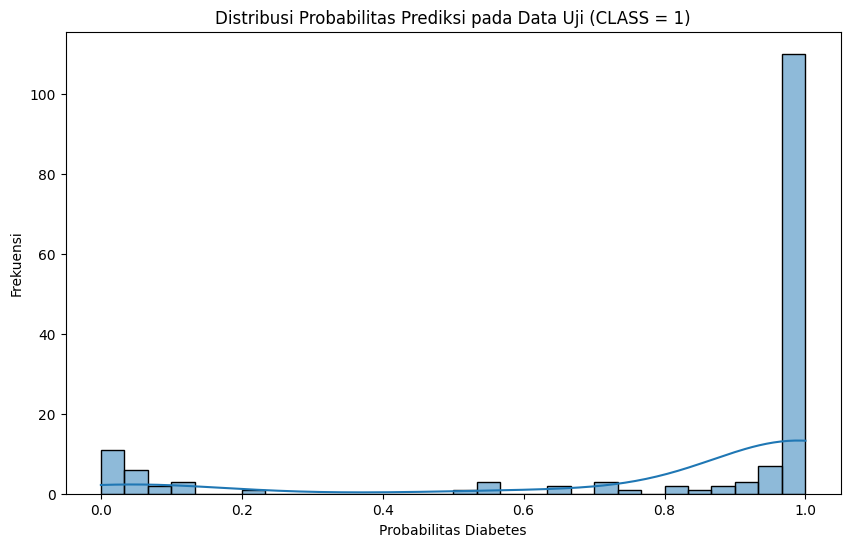

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define BNN Model
class BNN(PyroModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Lapisan pertama
        self.fc1 = PyroModule[torch.nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_dim, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([hidden_dim]).to_event(1))

        # Lapisan kedua
        self.fc2 = PyroModule[torch.nn.Linear](hidden_dim, output_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([output_dim, hidden_dim]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([output_dim]).to_event(1))

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x).squeeze(-1)
        probs = self.sigmoid(logits)

        # Distribusi Bernoulli untuk klasifikasi biner
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Bernoulli(probs), obs=y)
        return probs

# Define BNN Wrapper for scikit-learn
class BNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_dim=121, output_dim=1, lr=0.001, num_iterations=500):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = lr
        self.num_iterations = num_iterations
        self.model = None
        self.guide = None

    def fit(self, X, y):
        # Convert inputs to tensors
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        y = torch.tensor(y, dtype=torch.float32) if not isinstance(y, torch.Tensor) else y

        # Initialize model and guide
        self.model = BNN(self.input_dim, self.hidden_dim, self.output_dim)
        self.guide = AutoDiagonalNormal(self.model)
        adam = pyro.optim.Adam({"lr": self.lr})
        svi = SVI(self.model, self.guide, adam, loss=Trace_ELBO())

        # Train
        pyro.clear_param_store()
        losses = []
        for i in range(self.num_iterations):
            loss = svi.step(X, y)
            losses.append(loss / len(X))
            if i % 100 == 0:
                print(f"Iterasi {i}, Loss: {loss / len(X):.4f}")
        return self

    def predict_proba(self, X):
        # Ensure X is a PyTorch tensor
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=100)
        samples = predictive(X)
        probs = samples['obs'].detach().numpy().mean(axis=0)
        return np.vstack([1 - probs, probs]).T  # Shape (n_samples, 2) for binary classification

    def predict(self, X):
        # Ensure X is a PyTorch tensor
        X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        probs = self.predict_proba(X)[:, 1]
        return (probs > 0.5).astype(int)

# Setup hyperparameter search space
search_space = {
    'hidden_dim': Integer(16, 128),
    'lr': Real(0.0001, 0.01, prior='log-uniform')
}

# Initialize model wrapper
bnn_model = BNNWrapper(input_dim=X_train.shape[1], hidden_dim=121, output_dim=1, num_iterations=500)

# Perform tuning with Bayesian optimization
bayes_search = BayesSearchCV(
    bnn_model,
    search_space,
    n_iter=20,
    scoring='f1',
    cv=5,
    n_jobs=1,  # Sequential due to Pyro's nature
    verbose=1
)

# Run tuning on training data
bayes_search.fit(X_train.numpy(), y_train.numpy())

# Print best parameters and score
print("Best parameters:", bayes_search.best_params_)
print("Best F1 score:", bayes_search.best_score_)

# Evaluate on test set
best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_test.numpy())
y_pred_proba = best_model.predict_proba(X_test.numpy())[:, 1]

# Calculate metrics for testing set
accuracy = accuracy_score(y_test.numpy(), y_pred)
precision = precision_score(y_test.numpy(), y_pred)
recall = recall_score(y_test.numpy(), y_pred)
f1 = f1_score(y_test.numpy(), y_pred)
auc = roc_auc_score(y_test.numpy(), y_pred_proba)

print("\nEvaluasi Model BNN pada Data Uji:")
print(f"Akurasi: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Visualisasi distribusi probabilitas prediksi pada data uji
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, kde=True, bins=30)
plt.title("Distribusi Probabilitas Prediksi pada Data Uji (CLASS = 1)")
plt.xlabel("Probabilitas Diabetes")
plt.ylabel("Frekuensi")
plt.show()

# Evaluate on training set
y_train_pred = best_model.predict(X_train.numpy())
y_train_pred_proba = best_model.predict_proba(X_train.numpy())[:, 1]

# Calculate metrics for training set
train_accuracy = accuracy_score(y_train.numpy(), y_train_pred)
train_precision = precision_score(y_train.numpy(), y_train_pred)
train_recall = recall_score(y_train.numpy(), y_train_pred)
train_f1 = f1_score(y_train.numpy(), y_train_pred)
train_auc = roc_auc_score(y_train.numpy(), y_train_pred_proba)

print("\nEvaluasi Model BNN pada Data Latih:")
print(f"Akurasi: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"AUC-ROC: {train_auc:.4f}")

# Visualisasi distribusi probabilitas prediksi pada data latih
plt.figure(figsize=(10, 6))
sns.histplot(y_train_pred_proba, kde=True, bins=30)
plt.title("Distribusi Probabilitas Prediksi pada Data Latih (CLASS = 1)")
plt.xlabel("Probabilitas Diabetes")
plt.ylabel("Frekuensi")
plt.show()


Evaluasi Model BNN pada Data Latih:
Akurasi: 0.9784
Precision: 0.9872
Recall: 0.9694
F1-Score: 0.9782
AUC-ROC: 0.9980


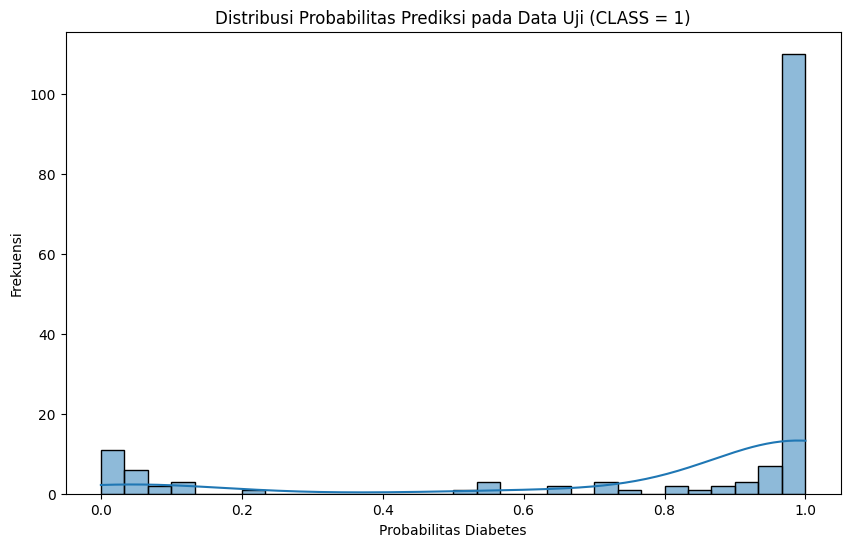

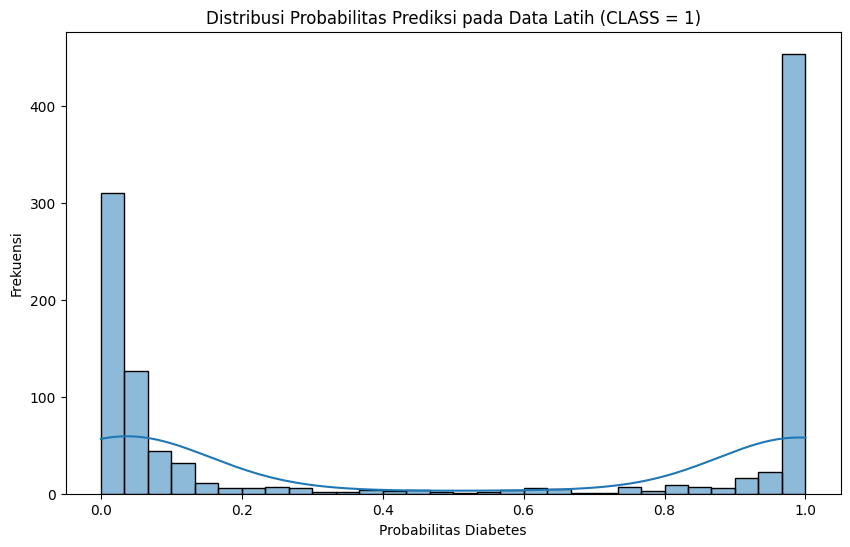

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, save_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negatif (0)', 'Positif (1)'],
                yticklabels=['Negatif (0)', 'Positif (1)'])
    plt.title(title)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.savefig(save_path)
    plt.close()

# Get predictions for training data
y_pred_train = best_model.predict(X_train.numpy())
y_train_np = y_train.numpy()
y_pred_train_np = y_pred_train

# Plot confusion matrix for training data
plot_confusion_matrix(y_train_np, y_pred_train_np,
                      'Confusion Matrix untuk Data Latih (BNN)',
                      'bnn_confusion_matrix_train.png')

# Get predictions for test data (already computed as y_pred)
y_test_np = y_test.numpy()
y_pred_test_np = y_pred

# Plot confusion matrix for test data
plot_confusion_matrix(y_test_np, y_pred_test_np,
                      'Confusion Matrix untuk Data Uji (BNN)',
                      'bnn_confusion_matrix_test.png')